 #          BOOK RECOMMENDATION SYSTEM

# Importing the required libraries

In [ ]:
import numpy as np 
import pandas as pd
import os
#import stdiomask
# seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import ssl
import smtplib
from pyspark import SparkConf, SparkContext
from multiprocessing import Pool
import os
os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3"

In [14]:
import numpy as np 
import pandas as pd

In [15]:
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('books.csv', error_bad_lines = False)

# Connecting to Cassandra

In [16]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

In [17]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('cmpe266')

In [18]:
rows = session.execute('select * from books;')
df_cas = pd.DataFrame(rows._current_rows)
df_cas.head()

,bookid,authors,average_rating,isbn,isbn13,language_code,num_pages,publication_date,publisher,ratings_count,text_reviews_count,title
0,39433,Bruce Cumings,3.77,393327027,9.78039E+12,eng,544,9/17/2005,W. W. Norton Company,647,67,Korea's Place in the Sun: A Modern History
1,37032,Susan Hill,3.95,701179791,9.7807E+12,eng,320,7/1/2006,Chatto & Windus,3060,264,The Risk of Darkness (Simon Serrailler #3)
2,1584,W. John Campbell,2.80,822007762,49086007763,eng,80,12/29/1983,Cliffs Notes,5,0,Cliffs Notes on Aristophanes' Lysistrata The ...
3,7034,Alexander McCall Smith,4.08,140007570X,9.7814E+12,eng,256,3/14/2006,Anchor,1070,73,In the Company of Cheerful Ladies (No. 1 Ladie...
4,23912,William Blake/Alicia Suskin Ostriker,4.24,140422153,9.78014E+12,eng,1072,11/24/1977,Penguin Classics,7738,48,The Complete Poems


In [6]:
df.index = df['bookID']

In [7]:
#Finding Number of rows and columns
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))

Dataset contains 11123 rows and 12 columns


# Data Parallelization

In [8]:
num_partitions = 10 #number of partitions to split dataframe
num_cores = 4 #number of cores on your machine


In [9]:
def parallelize_dataframe(df):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    pool.close()
    pool.join()
    return df

In [10]:
df = parallelize_dataframe(df)

In [11]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


# Resolving Cold Start Problem

In [12]:
def sendMailColdStart(recommendationBookList):
    sender_email = "cmpe.266@gmail.com"
    # receiver_email = "vineet.khatwal@sjsu.edu", "aayushi.gupta@sjsu.edu", "girish.chhabra@sjsu.edu"
    receiver_email = "vineet.khatwal@sjsu.edu"
    password = 'Cmpe266@123'
    message = MIMEMultipart("alternative")
    message["Subject"] = "Hi Reader ! Get the latest reading trends | TEAM 13"
    message["From"] = "cmpe.266@gmail.com"
    message["To"] = ", ".join(receiver_email)

    print("================== Composing the mail ================== ")
    # Create the plain-text and HTML version of your message
    html = """\
    <html>
        <head></head>
        <body>
            {0}
        </body>
    </html>
    """.format(recommendationBookList.to_html())

    # Turn these into plain/html MIMEText objects
    part1 = MIMEText(html, 'html')

    # Add HTML/plain-text parts to MIMEMultipart message
    # The email client will try to render the last part first
    message.attach(part1)

    # Create secure connection with server and send email
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(
            sender_email, receiver_email, message.as_string()
        )

    print("==================   Main sent ================== ")

In [13]:
bestRated = df[df['ratings_count'] > 100]
bestRated = bestRated.sort_values(by ='average_rating' , ascending=False)
bestRated = bestRated[['title','authors','average_rating']]
bestRated = bestRated.head(10)
sendMailColdStart(bestRated)


================== Composing the mail ================== 
==================   Main sent ================== 


In [14]:
bestRated

,title,authors,average_rating
bookID,,,
24812,The Complete Calvin and Hobbes,Bill Watterson,4.82
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78
24814,It's a Magical World (Calvin and Hobbes #11),Bill Watterson,4.76
6550,Early Color,Saul Leiter/Martin Harrison,4.73
10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73
34545,Elliott Erwitt: Snaps,Murray Sayle/Charles Flowers/Elliott Erwitt,4.72
24816,Homicidal Psycho Jungle Cat (Calvin and Hobbes...,Bill Watterson,4.72
24820,Calvin and Hobbes: Sunday Pages 1985-1995: An ...,Bill Watterson,4.71
44826,The Price of the Ticket: Collected Nonfiction ...,James Baldwin,4.70


In [15]:
maxRatingCount = df.sort_values(by ='ratings_count' , ascending=False)
maxRatingCount = maxRatingCount[['title','authors','ratings_count']]
maxRatingCount = maxRatingCount.head(10)
maxRatingCount

,title,authors,ratings_count
bookID,,,
41865,Twilight (Twilight #1),Stephenie Meyer,4597666
5907,The Hobbit or There and Back Again,J.R.R. Tolkien,2530894
5107,The Catcher in the Rye,J.D. Salinger,2457092
960,Angels & Demons (Robert Langdon #1),Dan Brown,2418736
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,2339585
15881,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling/Mary GrandPré,2293963
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,2153167
34,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien,2128944
7613,Animal Farm,George Orwell/Boris Grabnar/Peter Škerl,2111750


In [16]:
sendMailColdStart(maxRatingCount)

================== Composing the mail ================== 
==================   Main sent ================== 


# Conecting to the Client

In [17]:
client = gr.Client(developer_key= 'fgwnppR6Q1wpFt0n6umUQ') 

In [18]:
# Creating a function to get book details from the ISBN 13 value.

#Alternate scraping solution, when both the API(s) fails
def htmlFunction(isbn):
    url = 'https://isbndb.com/book/'+isbn
    articleVal = Article(url)
    #article = 'https://isbndb.com/book/9780450524684'
    articleVal.download()
    articleVal.parse()
    arVal = articleVal.html
    arVal = arVal[9300:9900]
    return arVal



In [19]:
# The finction for getting the final dataframe for the charts
def final_df(df1, l):
    year_df = pd.DataFrame(l, columns=['Year'])
    df1 = df1.reset_index(drop=True)
    final = df1[['authors', 'average_rating', 'title']].join(year_df)
    return final

In [20]:
#Finding the top 15 authors with the most number of books
df['authors'].value_counts().head(10)

P.G. Wodehouse         40
Stephen King           40
Rumiko Takahashi       39
Orson Scott Card       35
Agatha Christie        33
Piers Anthony          30
Sandra Brown           29
Mercedes Lackey        29
Dick Francis           28
Laurell K. Hamilton    23
Name: authors, dtype: int64

In [21]:
df.average_rating.isnull().value_counts()

False    11123
Name: average_rating, dtype: int64

In [22]:
df.dropna(0, inplace=True)
#Removing Any null values

In [23]:
def segregationFunc(data):
    valuesData = []
    for i in data.average_rating:
        if i>=0 and i<=1:
            valuesData.append("Between 0 and 1")
        elif i>1 and i<=2:
            valuesData.append("Between 1 and 2")
        elif i>2 and i<=3:
            valuesData.append("Between 2 and 3")
        elif i>3 and i<=4:
            valuesData.append("Between 3 and 4")
        elif i>4 and i<=5:
            valuesData.append("Between 4 and 5")
        else:
            valuesData.append("NaN")
    return valuesData

In [24]:
df['Ratings_Dist'] = segregationFunc(df)


In [25]:
tempTrial = df[~(df.ratings_count>2000000)]

In [26]:
tempTrial = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(tempTrial['average_rating']), np.asarray(tempTrial['ratings_count'])]).T

# Using the Elbow Curve

Text(0.5, 1.0, 'Elbow Curve')

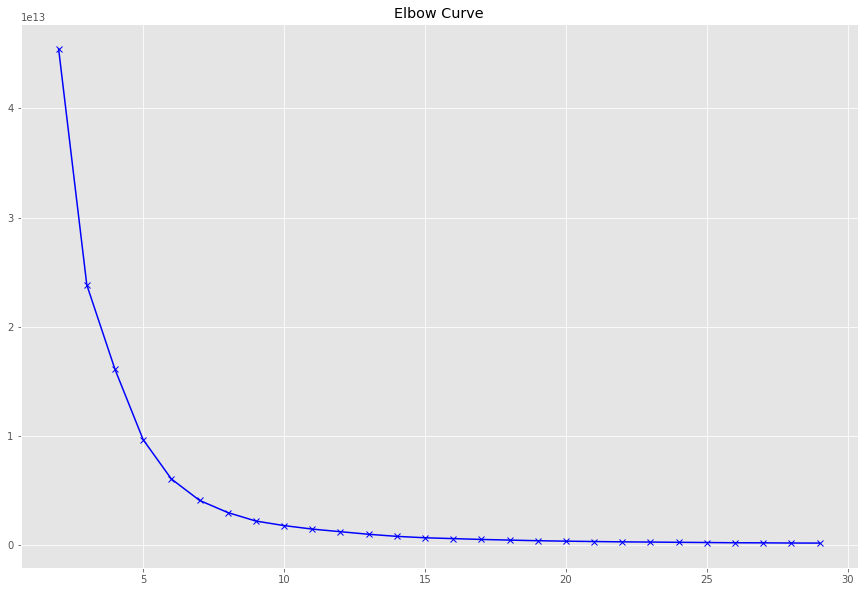

In [27]:
X = data
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

In [28]:
#Computing K means with K = 5, thus, taking it as 5 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

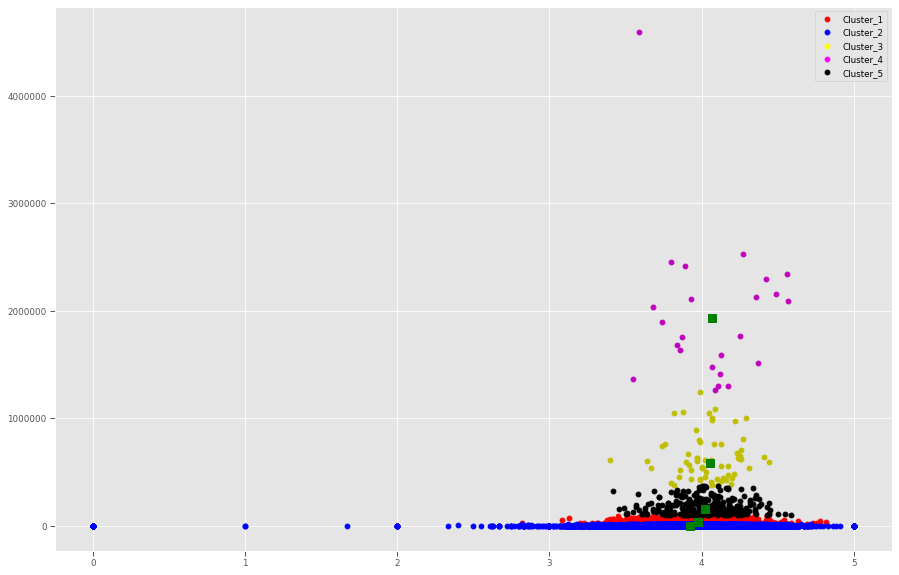

In [29]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
        
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )


circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster_1','Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5'), numpoints = 1, loc = 0, )


plt.show()

In [30]:
tempTrial.idxmax()

average_rating     2034
ratings_count     41865
dtype: int64

In [31]:
tempTrial.head()

,average_rating,ratings_count
bookID,,
1,4.57,2095690
2,4.49,2153167
4,4.42,6333
5,4.56,2339585
8,4.78,41428


In [32]:
tempTrial.drop(41865, inplace = True)

In [33]:
data = np.asarray([np.asarray(tempTrial['average_rating']), np.asarray(tempTrial['ratings_count'])]).T

In [34]:
#Computing K means with K = 8, thus, taking it as 8 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

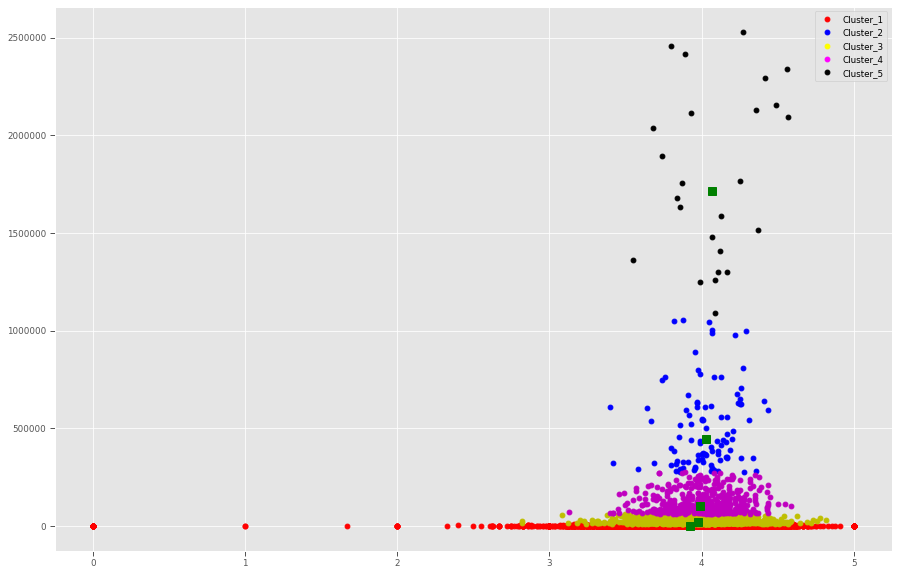

In [35]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
    
     
        
        
        
        
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )




circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster_1','Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5'), numpoints = 1, loc = 0, )


plt.show()

In [36]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Ratings_Dist
bookID,,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,Between 4 and 5
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,Between 4 and 5
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Between 4 and 5
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,Between 4 and 5
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,Between 4 and 5


In [37]:
booksfeatures = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)

In [38]:
booksfeatures.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.57,2095690
2,0,0,0,0,1,4.49,2153167
4,0,0,0,0,1,4.42,6333
5,0,0,0,0,1,4.56,2339585
8,0,0,0,0,1,4.78,41428


In [39]:
minMaxScaler = MinMaxScaler()
booksfeatures = minMaxScaler.fit_transform(booksfeatures)

In [40]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(booksfeatures)
distance, indices = model.kneighbors(booksfeatures)

In [41]:
def getindexfromname(name):
    return df[df["title"]==name].index.tolist()[0]

all_books_names = list(df.title.values)



In [42]:
def getIdFromPartialName(partial):
    for name in all_books_names:
        if partial in name:
            print(name,all_books_names.index(name))
            


In [43]:
def printSimilarBooks(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["title"])
    if query:
        found_id = getindexfromname(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["title"])

In [44]:
printSimilarBooks("The Catcher in the Rye")

Hitchhiker's Guide To The Galaxy: The Filming of the Douglas Adams classic
The Peloponnesian War
Henry and June: From the Unexpurgated Diary of Anaïs Nin
Hemingway & Bailey's Bartending Guide to Great American Writers
Liberty Before Liberalism


In [45]:
getIdFromPartialName("Harry Potter and the ")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Order of the Phoenix (Harry Potter  #5) 1
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 8873
Harry Potter and the Philosopher's Stone (Harry Potter  #1) 10674
Harry Potter and the Goblet of Fire (Harry Potter  #4) 10675


In [46]:
printSimilarBooks(id = 1) #ID for the Book 5

Harry Potter and the Half-Blood Prince (Harry Potter  #6)
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
The Hobbit  or There and Back Again


In [47]:
title = df[df.bookID==1]
temp = title['title']
book_title = temp[1]
book_title

'Harry Potter and the Half-Blood Prince (Harry Potter  #6)'

In [48]:
column_names = ["Title"]

mailDF = pd.DataFrame(columns = column_names )

# Finding Similar Books

In [49]:

bookTitle = ""
recommendationBookList = []
def mailSimilarBooks(id=None):
    if id:
        bookTitle = df[df['bookID']== id] 
        i = 0 
        for id in indices[id][1:]:
            if df.iloc[id]["title"] != book_title:
                recommendationBookList.append(df.iloc[id]["title"])
                mailDF.loc[i] = [df.iloc[id]["title"]]
            i+=1

In [50]:
mailSimilarBooks(id=1)

In [51]:
recommendationBookList

['The Fellowship of the Ring (The Lord of the Rings  #1)',
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)',
 'The Hobbit  or There and Back Again']

# Recommedation List

In [52]:
mailDF

,Title
1,The Fellowship of the Ring (The Lord of the Ri...
2,Harry Potter and the Chamber of Secrets (Harry...
3,Harry Potter and the Prisoner of Azkaban (Harr...
4,The Hobbit or There and Back Again


# Sending Mail

In [53]:
def sendMail(recommendationBookList, title):
    for i in recommendationBookList:
        print(i)
    sender_email = "cmpe.266@gmail.com"
    #receiver_email = "vineet.khatwal@sjsu.edu", "aayushi.gupta@sjsu.edu"
    receiver_email = "vineet.khatwal@sjsu.edu"
    password = 'Cmpe266@123'
    message = MIMEMultipart("alternative")
    message["Subject"] = "Hi Reader ! Recommendation for you from CMPE 266 : Team 13"
    message["From"] = "cmpe.266@gmail.com"
    message["To"] = ", ".join(receiver_email)

    print("================== Composing the mail ================== ")
    # Create the plain-text and HTML version of your message
    text = """\
    Hi Reader,
    How are you?
    Add more books to your reading bucket list.
    We are glad you liked the book : """ + title + """
    We think you will also like:
    """ + '\n' + '\n'.join(["- " + item for item in recommendationBookList]) + "\n\n" + """
    Enjoy your Reading time,
    CMPE 266 | TEAM 13
    """

    # Turn these into plain/html MIMEText objects
    part1 = MIMEText(text, "plain")

    # Add HTML/plain-text parts to MIMEMultipart message
    # The email client will try to render the last part first
    message.attach(part1)

    # Create secure connection with server and send email
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(
            sender_email, receiver_email, message.as_string()
        )

    print("==================   Main sent ================== ")

In [54]:
#sendMail(mailDF[['Title']], title)
sendMail(recommendationBookList, book_title)

The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
The Hobbit  or There and Back Again
================== Composing the mail ================== 
==================   Main sent ================== 
